In [1]:
# check that you're in python 2
import sys
assert sys.version[0] == '2'

In [2]:
import pandas as pd
import os
import zipfile
import StringIO
import requests
import statsmodels.api as sm
import patsy
import numpy as np
from IPython.display import clear_output

import matplotlib.pyplot as plt
import seaborn
seaborn.set_style('white')
%matplotlib inline

In [3]:
# Only set this to true if you want to redownload all the 10s of gigabytes of raw data
REDOWNLOAD_RAW = False
if REDOWNLOAD_RAW:
    raw_input("Are you sure you want to redownload everything?")

In [133]:
SAVE_FIGS = True

In [5]:
COLORS = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]

In [6]:
START_YEAR = 1979
END_YEAR = 2019

# Death data

In [86]:
BASE_URL = "https://www.nber.org/mortality/{0}/mort{0}.csv.zip"
URL_2019 = "http://data.nber.org/mortality/2019/nber_output/mortality_2019_nber_us.csv"  # changed for 2019...
DOWNLOAD_DEST_BASE = 'nchs_mcd_rawdata'

In [87]:
# If raw data folder doesn't exist, create it
if not os.path.exists(DOWNLOAD_DEST_BASE):
    print 'Making "{0}" directory...'.format(DOWNLOAD_DEST_BASE)
    os.makedirs('{0}'.format(DOWNLOAD_DEST_BASE))

In [88]:
def download_raw_data_by_year(year, base_url=BASE_URL, download_dest_base=DOWNLOAD_DEST_BASE):
    """
    See documentation stuff here:
    https://www.nber.org/data/vital-statistics-mortality-data-multiple-cause-of-death.html
    """
    year = str(year)
    
    # Check if already exists
    if os.path.exists(os.path.join(download_dest_base, '{0}.csv'.format(year))):
        if not REDOWNLOAD_RAW:
            print "Already have raw mortality data for {0}".format(year)
            return
        else:
            print "Redownloading raw mortality data for {0}!!!!!!!!!!!!!!!!!!!!!!!".format(year)
    
    # Specify file locations
    url = base_url.format(year)
    download_dest = os.path.join(download_dest_base, year)

    # Download data
    r = requests.get(url, stream=True)
    with zipfile.ZipFile(StringIO.StringIO(r.content)) as zf:
        zf.extractall(download_dest)

    # Move CSV to main directory and delete empty folder
    # nber filenames changed?
    try:
        current_filename = os.path.join(download_dest, 'mort{0}.csv'.format(year))
        new_filename = os.path.join(download_dest_base, '{0}.csv'.format(year))
        os.rename(current_filename, new_filename)
        os.rmdir(os.path.join(download_dest_base, year))
    except:
        current_filename = os.path.join(download_dest, 'Mort{0}US.PubUse.csv'.format(year))
        new_filename = os.path.join(download_dest_base, '{0}.csv'.format(year))
        os.rename(current_filename, new_filename)
        os.rmdir(os.path.join(download_dest_base, year))
    
    print "Downloaded raw mortality data for {0}".format(year)

In [89]:
def download_raw_data_2019(url=URL_2019, download_dest_base=DOWNLOAD_DEST_BASE):
    df = pd.read_csv(url)
    download_dest = os.path.join(download_dest_base, '2019.csv')
    df.to_csv(download_dest)
    
    print "Downloaded raw mortality data for 2019"

In [90]:
def download_raw_data(start_year=START_YEAR, end_year=END_YEAR, 
                      base_url=BASE_URL, url_2019=URL_2019, download_dest_base=DOWNLOAD_DEST_BASE):
    actual_end_year = min(END_YEAR, 2018)
    years = range(start_year, actual_end_year+1)
    
    for year in years:
        download_raw_data_by_year(year, base_url, download_dest_base)
    
    if actual_end_year < 2019:
        download_raw_data_2019(url_2019, download_dest_base)

In [91]:
download_raw_data()

Already have raw mortality data for 1979
Already have raw mortality data for 1980
Already have raw mortality data for 1981
Already have raw mortality data for 1982
Already have raw mortality data for 1983
Already have raw mortality data for 1984
Already have raw mortality data for 1985
Already have raw mortality data for 1986
Already have raw mortality data for 1987
Already have raw mortality data for 1988
Already have raw mortality data for 1989
Already have raw mortality data for 1990
Already have raw mortality data for 1991
Already have raw mortality data for 1992
Already have raw mortality data for 1993
Already have raw mortality data for 1994
Already have raw mortality data for 1995
Already have raw mortality data for 1996
Already have raw mortality data for 1997
Already have raw mortality data for 1998
Already have raw mortality data for 1999
Already have raw mortality data for 2000
Already have raw mortality data for 2001
Already have raw mortality data for 2002
Already have raw

C:\Users\basil\Anaconda3\envs\py2\lib\site-packages\IPython\core\interactiveshell.py:2878: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Downloaded raw mortality data for 2019


# Population data

## Setup

In [95]:
OTHER_DATA_DEST_BASE = 'other_data'

In [38]:
# If raw data folder doesn't exist, create it
if not os.path.exists(OTHER_DATA_DEST_BASE):
    print 'Making "{0}" directory...'.format(DOWNLOAD_DEST_BASE)
    os.makedirs('{0}'.format(OTHER_DATA_DEST_BASE))

In [39]:
pop_filename = os.path.join(OTHER_DATA_DEST_BASE, 'pop_data.csv')
if os.path.exists(pop_filename):
    pop_data = pd.read_csv(pop_filename, index_col=0)
    pop_data = pop_data[[c for c in pop_data.columns if c != 'total']]
    pop_data.columns = [int(x) for x in pop_data.columns]
    print "Population data loaded, no need to run the rest of this section"
else:
    print "pop_data.csv not yet created -- load data using code below."

Population data loaded, no need to run the rest of this section


#### Use NBER data (doesn't work!)

In [ ]:
# This data only runs up through 2012, so I don't end up using it. Keeping it here to show that my population data
# directly downloaded from Census matches what NBER has up through 2012

## Load by decade

### 2010-2019

In [40]:
# Source url: https://www.census.gov/data/tables/time-series/demo/popest/2010s-national-detail.html
# Description: https://www2.census.gov/programs-surveys/popest/technical-documentation/file-layouts/2010-2018/nc-est2018-agesex-res.pdf
POP_DATA_URL_2010 = 'https://www2.census.gov/programs-surveys/popest/technical-documentation/file-layouts/2010-2019/nc-est2019-agesex-res.csv'

In [41]:
def download_2010_pop_data(pop_data_url_2010=POP_DATA_URL_2010):
    """
    Download population data from 2010-2018
    """
    # Download
    pop_data_2010_raw = pd.read_csv(pop_data_url_2010, index_col=None, header=0)
    
    # Clean
    col_map = {
        c: c[-4:]
        for c in pop_data_2010_raw.columns if 'POPESTIMATE' in c
    }
    col_map['AGE'] = 'age'
    col_map['SEX'] = 'sex'
    gender_map = {
        0: 'total',
        1: 'male',
        2: 'female',
    }

    pop_data_2010 = pop_data_2010_raw[col_map].rename(columns=col_map)
    pop_data_2010['sex'] = pop_data_2010['sex'].replace(gender_map)
    pop_data_2010['age'] = pop_data_2010['age'].replace(999, 'total')

    pop_data_2010 = (
        pop_data_2010
        .set_index(['sex', 'age'])
        .T
        .sort_index()
    )
    
    # Return
    return pop_data_2010['total'], pop_data_2010['male'], pop_data_2010['female']

In [42]:
def load_pop_data_2010(pop_data_url_2010=POP_DATA_URL_2010, other_data_dest_base=OTHER_DATA_DEST_BASE):
    total_filename = os.path.join(other_data_dest_base, 'pop_data_2010_total.csv')
    male_filename = os.path.join(other_data_dest_base, 'pop_data_2010_male.csv')
    female_filename = os.path.join(other_data_dest_base, 'pop_data_2010_female.csv')
    
    if os.path.exists(total_filename):
        print "Loading", total_filename
        pop_data_2010_total = pd.read_csv(total_filename, index_col=0)
        pop_data_2010_total.columns = [int(x) for x in pop_data_2010_total.columns if x != 'total'] + ['total']
    else:
        print "Downloading 2010-2018 population data"
        pop_data_2010_total, males, females = download_2010_pop_data(pop_data_url_2010)
        
        pop_data_2010_total.to_csv(total_filename)
        males.to_csv(male_filename)
        females.to_csv(female_filename)
        
        print "Saved", total_filename
        
    return pop_data_2010_total

In [43]:
pop_data_2010 = load_pop_data_2010()

Loading other_data\pop_data_2010_total.csv


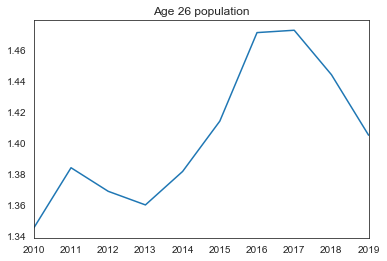

In [44]:
# sanity check
(pop_data_2010[26]*100./pop_data_2010['total']).plot()
_ = plt.title('Age 26 population')

### 2000-2009

In [50]:
# Source url: https://www.census.gov/data/datasets/time-series/demo/popest/intercensal-2000-2010-national.html
POP_DATA_URL_2000 = 'https://www2.census.gov/programs-surveys/popest/datasets/2000-2010/intercensal/national/us-est00int-alldata.csv'

In [51]:
pop_data_2000_raw = pd.read_csv(POP_DATA_URL_2000, index_col=None, header=0)

# Estimates are available for April and July (??), I use July.
pop_data_2000 = pop_data_2000_raw[pop_data_2000_raw['MONTH'] == 7]

In [52]:
def download_2000_pop_data(pop_data_url_2000=POP_DATA_URL_2000, month=7):
    """
    Download population data from 2000-2009
    Estimates are available for July, and also for April only in 2000 and 2010 (??), so I use July.
    """   
    # Download
    pop_data_2000_raw = pd.read_csv(pop_data_url_2000, index_col=None, header=0)
    
    # Estimates are available for April and July (??), I use July.
    pop_data_2000 = pop_data_2000_raw[pop_data_2000_raw['MONTH'] == month]

    # Clean
    def clean_pop_2000(df):
        df = df.rename(columns={999: 'total'})
        df.index.name = None
        df.columns.name = None
        return df

    pop_data_2000_total = pd.pivot_table(pop_data_2000, index='YEAR', columns='AGE', values='TOT_POP')
    pop_data_2000_male = pd.pivot_table(pop_data_2000, index='YEAR', columns='AGE', values='TOT_MALE')
    pop_data_2000_female = pd.pivot_table(pop_data_2000, index='YEAR', columns='AGE', values='TOT_FEMALE')

    pop_data_2000_total = clean_pop_2000(pop_data_2000_total)
    pop_data_2000_male = clean_pop_2000(pop_data_2000_male)
    pop_data_2000_female = clean_pop_2000(pop_data_2000_female)
    
    # Return
    return pop_data_2000_total, pop_data_2000_male, pop_data_2000_female

In [53]:
def load_pop_data_2000(pop_data_url_2000=POP_DATA_URL_2000, other_data_dest_base=OTHER_DATA_DEST_BASE):
    total_filename = os.path.join(other_data_dest_base, 'pop_data_2000_total.csv')
    male_filename = os.path.join(other_data_dest_base, 'pop_data_2000_male.csv')
    female_filename = os.path.join(other_data_dest_base, 'pop_data_2000_female.csv')
    
    if os.path.exists(total_filename):
        print "Loading", total_filename
        pop_data_2000_total = pd.read_csv(total_filename, index_col=0)
        pop_data_2000_total.columns = [int(x) for x in pop_data_2000_total.columns if x != 'total'] + ['total']
    else:
        print "Downloading 2000-2009 population data"
        pop_data_2000_total, males, females = download_2000_pop_data(pop_data_url_2000)
        
        pop_data_2000_total.to_csv(total_filename)
        males.to_csv(male_filename)
        females.to_csv(female_filename)
        
        print "Saved", total_filename
        
    return pop_data_2000_total

In [54]:
pop_data_2000 = load_pop_data_2000()

Loading other_data\pop_data_2000_total.csv


### 1990-2000

In [55]:
#https://www.census.gov/data/datasets/time-series/demo/popest/intercensal-1990-2000-national.html
POP_DATA_URL_1990 = 'https://www2.census.gov/programs-surveys/popest/datasets/1990-2000/intercensal/national/us-est90int-07.csv'

In [56]:
def download_1990_pop_data(pop_data_url_1990=POP_DATA_URL_1990, month=7):
    """
    Download population data from 1990-1999
    Estimates are available monthly, I use July.
    """   
    # Download
    pop_data_1990_raw = pd.read_csv(pop_data_url_1990, index_col=None, header=0, skiprows=1)
    
    # Clean
    # Relabel columns
    pop_data_1990 = pop_data_1990_raw.copy()
    pop_data_1990.columns = ['Date', 'Age', 'Total', 'Male', 'Female']
    # Drop bad rows
    pop_data_1990 = pop_data_1990['Int' != pop_data_1990['Date'].str[:3]]
    # Date
    pop_data_1990['Date'] = pd.to_datetime(pop_data_1990['Date'])
    pop_data_1990['Year'] = pop_data_1990['Date'].apply(lambda x: x.year)
    pop_data_1990['Month'] = pop_data_1990['Date'].apply(lambda x: x.month)
    # Age
    pop_data_1990['Age'] = pop_data_1990['Age'].replace('100+', '100')
    pop_data_1990['Age'] = pop_data_1990['Age'].replace('All Age', 'total')
    # Estimates are available quarterly, I use April.
    pop_data_1990 = pop_data_1990[pop_data_1990['Month'] == month]
    
    # Collect
    pop_data_1990_total = pd.pivot_table(pop_data_1990, index='Year', columns='Age', values='Total')
    pop_data_1990_male = pd.pivot_table(pop_data_1990, index='Year', columns='Age', values='Male')
    pop_data_1990_female = pd.pivot_table(pop_data_1990, index='Year', columns='Age', values='Female')
    
    # Clean moar
    def clean_pop_1990(df):
        df.index.name = None
        df.columns.name = None
        df.columns = [int(x) if x != 'total' else 'total' for x in df.columns]
        order = sorted(df.columns)
        return df[order]
    pop_data_1990_total = clean_pop_1990(pop_data_1990_total)
    pop_data_1990_male = clean_pop_1990(pop_data_1990_male)
    pop_data_1990_female = clean_pop_1990(pop_data_1990_female)
    
    # Return
    return pop_data_1990_total, pop_data_1990_male, pop_data_1990_female

In [57]:
def load_pop_data_1990(pop_data_url_1990=POP_DATA_URL_1990, other_data_dest_base=OTHER_DATA_DEST_BASE):
    total_filename = os.path.join(other_data_dest_base, 'pop_data_1990_total.csv')
    male_filename = os.path.join(other_data_dest_base, 'pop_data_1990_male.csv')
    female_filename = os.path.join(other_data_dest_base, 'pop_data_1990_female.csv')
    
    if os.path.exists(total_filename):
        print "Loading", total_filename
        pop_data_1990_total = pd.read_csv(total_filename, index_col=0)
        pop_data_1990_total.columns = [int(x) for x in pop_data_1990_total.columns if x != 'total'] + ['total']
    else:
        print "Downloading 1990-1999 population data"
        pop_data_1990_total, males, females = download_1990_pop_data(pop_data_url_1990)
        
        pop_data_1990_total.to_csv(total_filename)
        males.to_csv(male_filename)
        females.to_csv(female_filename)
        
        print "Saved", total_filename
        
    return pop_data_1990_total

In [58]:
pop_data_1990 = load_pop_data_1990()

Loading other_data\pop_data_1990_total.csv


### 1980-1990

In [59]:
# Source: https://www.census.gov/data/datasets/time-series/demo/popest/1980s-national.html
# Documentation: https://www2.census.gov/programs-surveys/popest/technical-documentation/file-layouts/1980-1990/nat-detail-layout.txt
POP_DATA_URLS_1980s = {
    1980: 'https://www2.census.gov/programs-surveys/popest/datasets/1980-1990/national/asrh/e8081rqi.zip',
    1981: 'https://www2.census.gov/programs-surveys/popest/datasets/1980-1990/national/asrh/e8182rqi.zip',
    1982: 'https://www2.census.gov/programs-surveys/popest/datasets/1980-1990/national/asrh/e8283rqi.zip',
    1983: 'https://www2.census.gov/programs-surveys/popest/datasets/1980-1990/national/asrh/e8384rqi.zip',
    1984: 'https://www2.census.gov/programs-surveys/popest/datasets/1980-1990/national/asrh/e8485rqi.zip',
    1985: 'https://www2.census.gov/programs-surveys/popest/datasets/1980-1990/national/asrh/e8586rqi.zip',
    1986: 'https://www2.census.gov/programs-surveys/popest/datasets/1980-1990/national/asrh/e8687rqi.zip',
    1987: 'https://www2.census.gov/programs-surveys/popest/datasets/1980-1990/national/asrh/e8788rqi.zip',
    1988: 'https://www2.census.gov/programs-surveys/popest/datasets/1980-1990/national/asrh/e8889rqi.zip',
    1989: 'https://www2.census.gov/programs-surveys/popest/datasets/1980-1990/national/asrh/e8990rqi.zip',
}

In [60]:
def download_1980_pop_data_by_year(year, pop_data_urls_1980s=POP_DATA_URLS_1980s, 
                                   other_data_dest_base=OTHER_DATA_DEST_BASE, month=7):
    """
    Download population data for a given year in 1980-1989
    Estimates are available quarterly, I use July.
    """   
    # Download zip for the year
    url = pop_data_urls_1980s[year]
    r = requests.get(url, stream=True)
    with zipfile.ZipFile(StringIO.StringIO(r.content)) as zf:
        zf.extractall(other_data_dest_base)    
    
    # Read in data (stored as a string wtf)
    year_str2 = str(year)[-2:]
    year_after_str2 = str(year+1)[-2:]
    raw_data_name = 'E{0}{1}RQI.TXT'.format(year_str2, year_after_str2)
    raw_data_path = os.path.join(other_data_dest_base, raw_data_name)
    raw_data = open(raw_data_path, 'r').readlines()

    pop_data_year = {
        'Month': {},
        'Year': {},
        'Age': {},
        'Total': {},
        'Male': {},
        'Female': {},
    }
    for row_num in range(len(raw_data)):
        row = raw_data[row_num]
        if len(row) < 40:
            continue
        #pop_data_year['series'][row_num] = row[0:2]
        pop_data_year['Month'][row_num] = int(row[2:4])
        pop_data_year['Year'][row_num] = int('19' + row[4:6])
        pop_data_year['Age'][row_num] = int(row[6:10])
        #pop_data_year['blank'][row_num] = row[10:11]
        pop_data_year['Total'][row_num] = int(row[11:21])
        pop_data_year['Male'][row_num] = int(row[21:31])
        pop_data_year['Female'][row_num] = int(row[31:41])
    
    # Clean up
    pop_data_year = pd.DataFrame(pop_data_year)
    os.remove(raw_data_path)
    
    # Clean
    pop_data_year['Age'] = pop_data_year['Age'].replace(999, 'total')
    pop_data_year = pop_data_year[pop_data_year['Year'] == year]
    pop_data_year = pop_data_year[pop_data_year['Month'] == month]

    
    return pop_data_year

In [61]:
def download_1980_pop_data(pop_data_urls_1980s=POP_DATA_URLS_1980s, 
                           other_data_dest_base=OTHER_DATA_DEST_BASE, month=7):
    """
    Download population data from 1980-1989
    Estimates are available monthly, I use July.
    """   
    # Download
    pop_data_1980_dict = {}
    for year in range(1980, 1990):
        pop_data_1980_dict[year] = download_1980_pop_data_by_year(year, pop_data_urls_1980s, 
                                                                  other_data_dest_base, month)
    pop_data_1980 = pd.concat(pop_data_1980_dict.values(), axis=0)
        
    # Collect
    pop_data_1980_total = pd.pivot_table(pop_data_1980, index='Year', columns='Age', values='Total')
    pop_data_1980_male = pd.pivot_table(pop_data_1980, index='Year', columns='Age', values='Male')
    pop_data_1980_female = pd.pivot_table(pop_data_1980, index='Year', columns='Age', values='Female')
    
    # Clean moar
    def clean_pop_1980(df):
        df.index.name = None
        df.columns.name = None
        df.columns = [int(x) if x != 'total' else 'total' for x in df.columns]
        order = sorted(df.columns)
        return df[order]
    pop_data_1980_total = clean_pop_1980(pop_data_1980_total)
    pop_data_1980_male = clean_pop_1980(pop_data_1980_male)
    pop_data_1980_female = clean_pop_1980(pop_data_1980_female)
    
    # Return
    return pop_data_1980_total, pop_data_1980_male, pop_data_1980_female

In [62]:
def load_pop_data_1980(pop_data_urls_1980s=POP_DATA_URLS_1980s, other_data_dest_base=OTHER_DATA_DEST_BASE):
    total_filename = os.path.join(other_data_dest_base, 'pop_data_1980_total.csv')
    male_filename = os.path.join(other_data_dest_base, 'pop_data_1980_male.csv')
    female_filename = os.path.join(other_data_dest_base, 'pop_data_1980_female.csv')
    
    if os.path.exists(total_filename):
        print "Loading", total_filename
        pop_data_1980_total = pd.read_csv(total_filename, index_col=0)
        pop_data_1980_total.columns = [int(x) for x in pop_data_1980_total.columns if x != 'total'] + ['total']
    else:
        print "Downloading 1990-1999 population data"
        pop_data_1980_total, males, females = download_1980_pop_data(pop_data_urls_1980s, other_data_dest_base)
        
        pop_data_1980_total.to_csv(total_filename)
        males.to_csv(male_filename)
        females.to_csv(female_filename)
        
        print "Saved", total_filename
        
    return pop_data_1980_total

In [63]:
pop_data_1980 = load_pop_data_1980()

Loading other_data\pop_data_1980_total.csv


### <1980

In [64]:
#TODO
#https://www.census.gov/data/tables/time-series/demo/popest/pre-1980-national.html

### Combine

In [65]:
# Note that the "max bucket" varies over time, but doesn't matter for our purposes
# See https://www.census.gov/dataviz/visualizations/055/

In [66]:
dict_of_pop_data = {
    '2010-2017': pop_data_2010,
    '2000-2009': pop_data_2000.loc[2000:2009],
    '1990-1999': pop_data_1990,
    '1980-1989': pop_data_1980,
    #'<1980': None,
}

In [67]:
pop_data = pd.concat(dict_of_pop_data.values(), axis=0)
pop_data = pop_data.fillna(0)
pop_data = pop_data.sort_index()

clear_output() # stupid warning

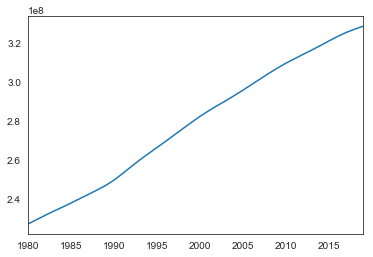

In [68]:
# Sanity check
pop_data['total'].plot()

In [69]:
# Save
pop_data.to_csv(os.path.join(OTHER_DATA_DEST_BASE, 'pop_data.csv'))

# Get just suicide data

In [70]:
CLEAN_DATA_BASE = 'cleaned_data'

In [71]:
if not os.path.exists(CLEAN_DATA_BASE):
    os.makedirs(CLEAN_DATA_BASE)
    print "Created", CLEAN_DATA_BASE

In [106]:
# See Hansen and Lang (2011), "Data" section; or individual documentation files linked from NBER
DEATH_VAR_MAP = {}
SUICIDE_VAL_MAP = {}
#for year in range(1968, 1979):
    # ICDA-8
    # https://www.nber.org/mortality/www.cdc.gov/nchs/data/dvs/dt78icd8.pdf
    #DEATH_VAR_MAP[year] = 'ucr34'
    #SUICIDE_VAL_MAP[year] = 350
for year in range(1979, 1999):
    # ICDA-9
    # https://www.nber.org/mortality/1998/desc_mort1998.txt
    DEATH_VAR_MAP[year] = 'ucr34'
    SUICIDE_VAL_MAP[year] = 350
for year in range(1999, 2020):
    # ICDA-10
    # https://www.nber.org/mortality/1999/desc_mort1999.txt
    DEATH_VAR_MAP[year] = 'ucr39'
    SUICIDE_VAL_MAP[year] = 40

In [107]:
def get_suicide_data(death_var_map=DEATH_VAR_MAP, suicide_val_map=SUICIDE_VAL_MAP,
                     start_year=START_YEAR, end_year=END_YEAR,
                     raw_data_loc_base=DOWNLOAD_DEST_BASE, suicide_data_loc_base=CLEAN_DATA_BASE):
    for year in reversed(range(start_year, end_year+1)):
        # Check if already exists
        new_filename = os.path.join(suicide_data_loc_base, '{0}.csv'.format(year))
        if os.path.exists(new_filename):
            print new_filename, "already exists"
            continue

        # Set appropriate variables
        death_var = death_var_map[int(year)]
        suicide_val = suicide_val_map[int(year)]
        
        # Get data
        get_suicide_data_by_year(death_var, suicide_val, year, raw_data_loc_base, suicide_data_loc_base)

In [108]:
def get_suicide_data_by_year(death_var, suicide_val, year,
                             raw_data_loc_base=DOWNLOAD_DEST_BASE, suicide_data_loc_base=CLEAN_DATA_BASE):
    # Check if already exists
    new_filename = os.path.join(suicide_data_loc_base, '{0}.csv'.format(year))
    if os.path.exists(new_filename):
        print new_filename, "already exists"
        return

    # Load data
    print "Loading", year
    filename = os.path.join(raw_data_loc_base, '{0}.csv'.format(year))
    data = pd.read_csv(filename)

    # Filter to just suicides
    suicide_data = data[data[death_var] == suicide_val]

    # Extract age
    if (year <= 2002) & (year >= 1979):    # this might work for prior to 1979 as well, but haven't checked codebooks
        # See "Detail Age": https://www.nber.org/mortality/2002/mort2002.pdf
        # above 99 label as 100
        suicide_data.loc[(suicide_data['age'] > 100) & (suicide_data['age'] < 200), 'age'] = 100
        # months/weeks/days/hours/minutes report as 0
        suicide_data.loc[(suicide_data['age'] > 200) & (suicide_data['age'] < 700), 'age'] = 0
        # drop unknowns
        clean_suicide_data = suicide_data[suicide_data['age'] != 999]
    elif year >= 2003:
        # See "Detail Age": https://www.nber.org/mortality/2003/mort2003.pdf
        age_in_years = (suicide_data['age'] > 1000) & (suicide_data['age'] < 2000)
        age_zero = (suicide_data['age'] > 2000) & (suicide_data['age'] < 7000)
        not_missing = suicide_data['age'] != 9999
        # get age for 1+
        suicide_data.loc[age_in_years, 'age'] -= 1000
        # months/weeks/days/hours/minutes report as 0
        suicide_data.loc[age_zero, 'age'] = 0
        # above 99 label as 100
        suicide_data.loc[(suicide_data['age'] > 100) & not_missing, 'age'] = 100
        # drop unknowns
        clean_suicide_data = suicide_data.loc[not_missing]

    # Drop irrelevant vars
    final_suicide_data = clean_suicide_data[['sex', 'age', 'monthdth']].copy()
    final_suicide_data = final_suicide_data.rename(columns={'monthdth': 'month'})
    final_suicide_data['year'] = year

    # Get sex
    # TODO: ...confirm
    # final_suicide_data['sex'].replace(1, 'M').replace(2, 'F')

    # Save data
    final_suicide_data.to_csv(new_filename)
    print "Saved", new_filename

In [109]:
get_suicide_data()

Loading 2019


C:\Users\basil\Anaconda3\envs\py2\lib\site-packages\IPython\core\interactiveshell.py:2878: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\basil\Anaconda3\envs\py2\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Saved cleaned_data\2019.csv
Loading 2018


C:\Users\basil\Anaconda3\envs\py2\lib\site-packages\IPython\core\interactiveshell.py:2878: DtypeWarning: Columns (66,69,72,100,101,102,103) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Saved cleaned_data\2018.csv
cleaned_data\2017.csv already exists
cleaned_data\2016.csv already exists
cleaned_data\2015.csv already exists
cleaned_data\2014.csv already exists
cleaned_data\2013.csv already exists
cleaned_data\2012.csv already exists
cleaned_data\2011.csv already exists
cleaned_data\2010.csv already exists
cleaned_data\2009.csv already exists
cleaned_data\2008.csv already exists
cleaned_data\2007.csv already exists
cleaned_data\2006.csv already exists
cleaned_data\2005.csv already exists
cleaned_data\2004.csv already exists
cleaned_data\2003.csv already exists
cleaned_data\2002.csv already exists
cleaned_data\2001.csv already exists
cleaned_data\2000.csv already exists
cleaned_data\1999.csv already exists
cleaned_data\1998.csv already exists
cleaned_data\1997.csv already exists
cleaned_data\1996.csv already exists
cleaned_data\1995.csv already exists
cleaned_data\1994.csv already exists
cleaned_data\1993.csv already exists
cleaned_data\1992.csv already exists
cleaned_da

In [110]:
# example
df = pd.read_csv('cleaned_data/2019.csv', index_col=0)
df.sample(n=5)

,sex,age,month,year
1309381,F,54,4,2019
846905,M,40,12,2019
62353,M,76,2,2019
20006,M,35,4,2019
2316075,M,81,5,2019


In [111]:
# example
df = pd.read_csv('cleaned_data/2017.csv', index_col=0)
df.sample(n=5)

,sex,age,month,year
1842578,F,66,10,2017
938834,F,32,11,2017
1817012,M,61,7,2017
2288169,M,51,5,2017
713905,M,51,1,2017


In [112]:
# example
df = pd.read_csv('cleaned_data/1992.csv', index_col=0)
df.sample(n=5)

,sex,age,month,year
1020162,1,49,9,1992
1624118,1,59,8,1992
1975566,1,27,8,1992
1775005,1,75,12,1992
357564,1,38,9,1992


# Get deaths of despair 

In [113]:
# TODO

# Group by age and compute suicide rates

### Stack suicide data

In [114]:
START_YEAR = 1980
# 1980 not 1979 until we get population data for then

In [115]:
def stack_suicide_data(start_year=START_YEAR, end_year=END_YEAR, suicide_data_loc_base=CLEAN_DATA_BASE):
    data = {}
    for year in range(start_year, end_year+1):
        filename = os.path.join(suicide_data_loc_base, '{0}.csv'.format(year))
        data[year] = pd.read_csv(filename, index_col=0)
        
    stacked_data = pd.concat(data.values(), axis=0)
    return stacked_data, data

In [116]:
suicide_data, tmp = stack_suicide_data()

In [117]:
suicide_data.sample(n=5)

,sex,age,month,year
1842291,M,53,9,2018
487289,1,60,11,1989
1097445,M,55,10,2019
1923389,1,23,10,1986
503697,1,61,11,1991


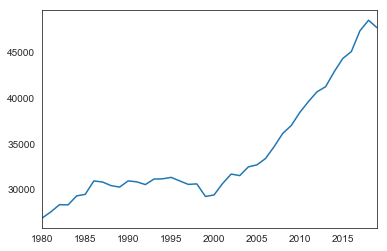

In [118]:
# jfc
suicide_data['year'].value_counts().sort_index().plot()

### Group suicide data by age

In [119]:
AGE_GROUPS = {
    '<14': range(0, 14),
    '14-18': range(14, 19),
    '19-25': range(19, 26),
    '>25': range(26, 101)
}

# alternative 1:
#AGE_GROUPS = {
#    '<18': range(0, 18),
#    '>=18': range(18, 101),
#}

# alternative 2:
#AGE_GROUPS = {
#    '<18': range(0, 18),
#    '18-25': range(18, 26),
#    '26+': range(26, 101)
#}

# alternative 3:
#AGE_GROUPS = {
#    '<6': range(6),
#    '07': [7],
#    '08': [8],
#    '09': [9],
#    '>60': range(61, 101)
#}
#for i in range(10, 61):
#    AGE_GROUPS[str(i)] = [i]

In [120]:
def get_age_order(age_groups):
    first_val = [k for k in age_groups if '<' in k]
    last_val = [k for k in age_groups if '>' in k]
    other = [k for k in age_groups if k not in first_val and k not in last_val]
    other = sorted(other)
    return first_val + other + last_val
# should output ['<15', '15-18', '19-25', '>25']
GROUP_ORDER = get_age_order(AGE_GROUPS)

In [121]:
def get_age_groups_map(age_groups):
    return {
        v: k
        for k in age_groups
        for v in age_groups[k]
    }
AGE_GROUPS_MAP = get_age_groups_map(AGE_GROUPS)

In [122]:
suicide_data['age_group'] = suicide_data['age'].map(AGE_GROUPS_MAP)

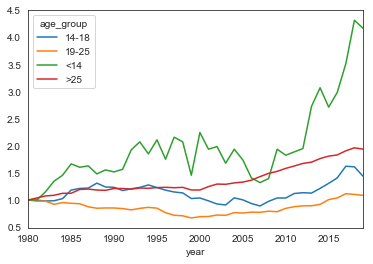

In [123]:
# :(((((((((((((
tmp = pd.pivot_table(data=suicide_data[['age_group', 'year']], index='year', columns='age_group', aggfunc=len)
(tmp/tmp.loc[1980]).plot()

In [124]:
suicide_counts_by_age_group_by_monthyear = (
    suicide_data[['year', 'month', 'age_group']]
    .groupby(['year', 'month', 'age_group'])
    .apply(len)
    .unstack()
    .fillna(0)
)

In [125]:
# preview
suicide_counts_by_age_group_by_monthyear.head()

age_group   14-18  19-25   <14     >25
year month                            
1980 1      114.0  377.0   7.0  1650.0
     2      102.0  376.0   8.0  1570.0
     3      112.0  401.0  10.0  1772.0
     4       86.0  391.0   9.0  1848.0
     5      103.0  367.0   4.0  1846.0

### Group population data by age

In [126]:
pop_by_group = pd.DataFrame()
for group_k, group_v in AGE_GROUPS.iteritems():
    pop_by_group[group_k] = pop_data[group_v].sum(1)
pop_by_group = pop_by_group[GROUP_ORDER]
pop_by_group.index.name = 'year'

In [127]:
blank_df = pd.DataFrame(index=suicide_counts_by_age_group_by_monthyear.index)
pop_by_group_by_monthyear = blank_df.join(pop_by_group)

In [128]:
# preview
pop_by_group_by_monthyear.head()

<14       14-18       19-25          >25
year month                                                 
1980 1      47540375.0  20372913.0  30006209.0  129305184.0
     2      47540375.0  20372913.0  30006209.0  129305184.0
     3      47540375.0  20372913.0  30006209.0  129305184.0
     4      47540375.0  20372913.0  30006209.0  129305184.0
     5      47540375.0  20372913.0  30006209.0  129305184.0

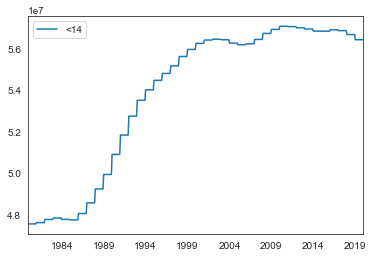

In [129]:
# preview
tmp_index = [pd.datetime(x[0], x[1], 1) for x in pop_by_group_by_monthyear.index]
tmp = pop_by_group_by_monthyear.copy()
tmp.index = tmp_index
tmp[['<14']].plot()

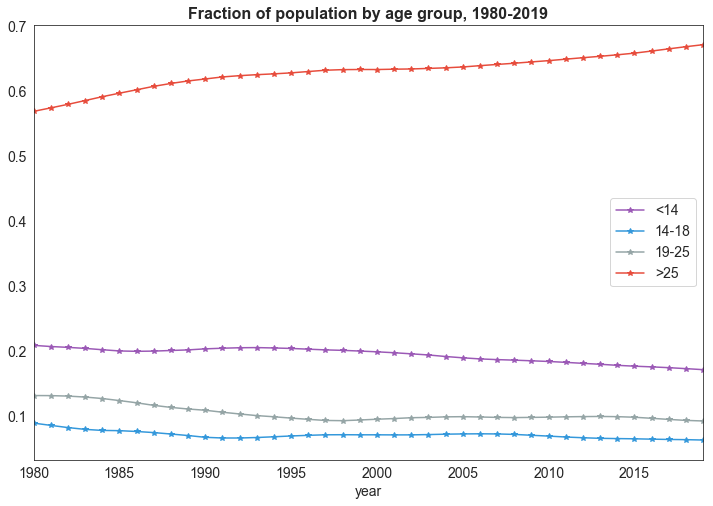

In [130]:
# population share trends
age_group_shares = pop_by_group.divide(pop_by_group.sum(1), axis=0)

age_group_shares.plot(figsize=(12, 8), style='-*', color=COLORS)
_ = plt.title('Fraction of population by age group, {0}-{1}'.format(START_YEAR, END_YEAR), fontsize=16, weight='heavy')
_ = plt.xticks(fontsize=14)
_ = plt.xlabel('year', fontsize=14)
_ = plt.yticks(fontsize=14)
_ = plt.legend(fontsize=14)
plt.savefig('figures/age_shares.png', dpi=300, bbox_inches='tight')

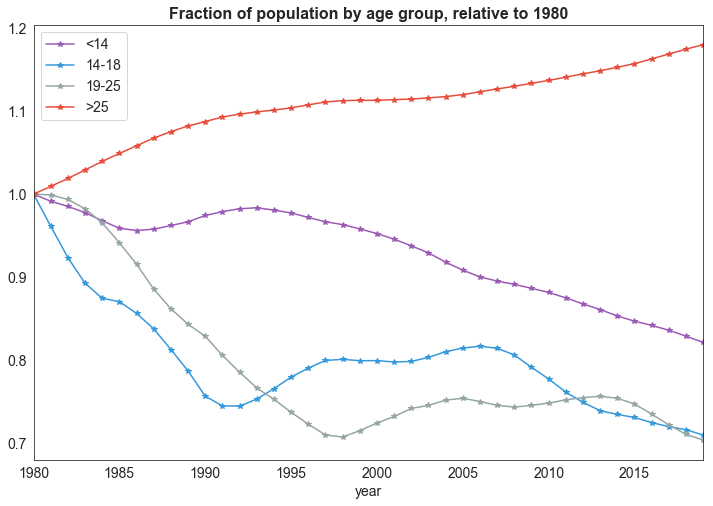

In [131]:
# population share relative to 1980
(age_group_shares/age_group_shares.loc[1980]).plot(figsize=(12, 8), style='-*', color=COLORS)
_ = plt.title('Fraction of population by age group, relative to 1980', fontsize=16, weight='heavy')
_ = plt.xticks(fontsize=14)
_ = plt.xlabel('year', fontsize=14)
_ = plt.yticks(fontsize=14)
_ = plt.legend(fontsize=14)
plt.savefig('figures/age_shares_relative_to_1980.png', dpi=300, bbox_inches='tight')

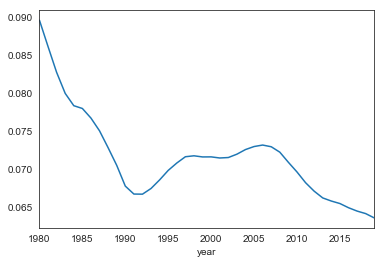

In [132]:
age_group_shares['14-18'].plot()

### Normalize suicide data by population data

In [135]:
# Get data by month-year
suicide_rate_by_monthyear = suicide_counts_by_age_group_by_monthyear/pop_by_group_by_monthyear

raw_suicide_rate_per100k_annualized_by_monthyear = suicide_rate_by_monthyear[GROUP_ORDER]*12*100000

In [136]:
new_index = [
    pd.datetime(x[0], x[1], 1) 
    for x 
    in raw_suicide_rate_per100k_annualized_by_monthyear.index
]
suicide_rate_per100k_annualized_by_monthyear = raw_suicide_rate_per100k_annualized_by_monthyear.copy()
suicide_rate_per100k_annualized_by_monthyear.index = new_index

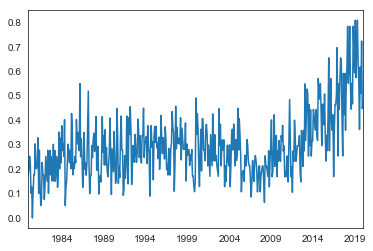

In [137]:
suicide_rate_per100k_annualized_by_monthyear['<14'].plot()

### Group by time unit

In [138]:
tmp = raw_suicide_rate_per100k_annualized_by_monthyear.reset_index()

In [139]:
# Get by month
suicide_rate_per100k_annualized_by_month = tmp.groupby('month').mean()[GROUP_ORDER]
# preview
suicide_rate_per100k_annualized_by_month.head()

,<14,14-18,19-25,>25
month,,,,
1,0.332630,8.351772,14.487240,15.823328
2,0.318148,7.499289,12.926622,14.513221
3,0.349059,8.078998,14.519148,16.604678
4,0.321206,7.871620,14.205629,16.349807
5,0.316410,7.714503,14.520340,16.895665


In [140]:
# Get by year
suicide_rate_per100k_by_year = tmp.groupby('year').sum()[GROUP_ORDER]/12

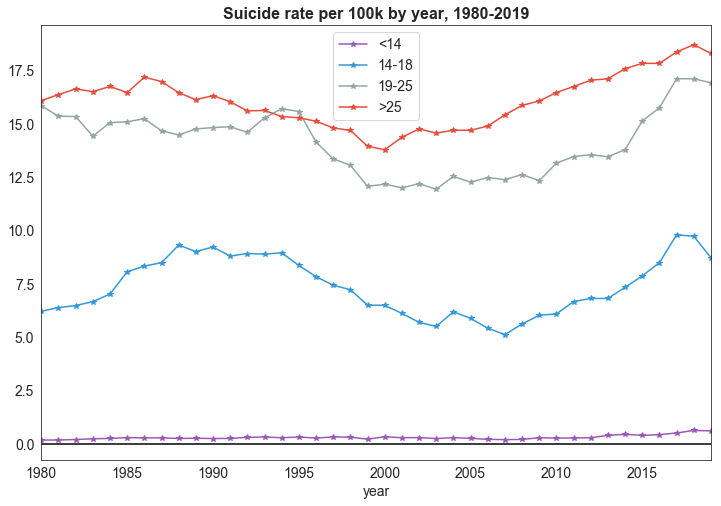

In [141]:
suicide_rate_per100k_by_year.plot(figsize=(12, 8), style='-*', color=COLORS)
_ = plt.title('Suicide rate per 100k by year, {0}-{1}'.format(START_YEAR, END_YEAR), fontsize=16, weight='heavy')
_ = plt.xticks(fontsize=14)
_ = plt.xlabel('year', fontsize=14)
_ = plt.yticks(fontsize=14)
_ = plt.axhline(0.0, color='k')
_ = plt.legend(fontsize=14)
if SAVE_FIGS:
    plt.savefig('figures/suicide_rate_by_year.png', dpi=300, bbox_inches='tight')

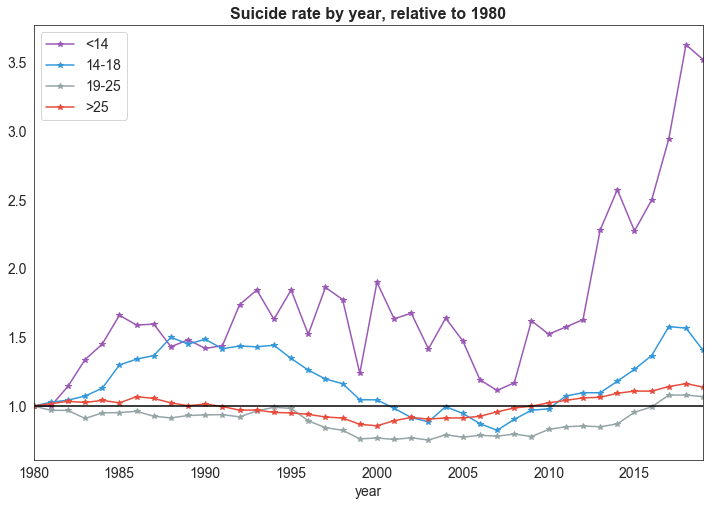

In [142]:
(
    suicide_rate_per100k_by_year/suicide_rate_per100k_by_year.loc[1980]
).plot(figsize=(12, 8), style='-*', color=COLORS)
_ = plt.title('Suicide rate by year, relative to 1980', fontsize=16, weight='heavy')
_ = plt.xticks(fontsize=14)
_ = plt.xlabel('year', fontsize=14)
_ = plt.yticks(fontsize=14)
_ = plt.axhline(1.0, color='k')
_ = plt.legend(fontsize=14)
if SAVE_FIGS:
    plt.savefig('figures/suicide_rate_rel_to_1980.png', dpi=300, bbox_inches='tight')

# Plotting rates

### Setup

In [143]:
year_range_str = ', ' + str(START_YEAR) + '-' + str(END_YEAR)

In [144]:
months_map = {
    1: 'Jan.',
    2: 'Feb.',
    3: 'Mar.',
    4: 'Apr.',
    5: 'May',
    6: 'June',
    7: 'July',
    8: 'Aug.',
    9: 'Sep.',
    10: 'Oct.',
    11: 'Nov.',
    12: 'Dec.',
}

### All at once

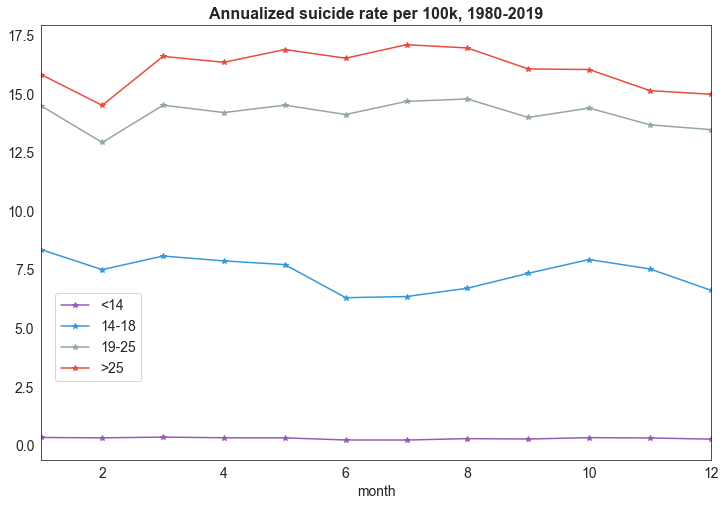

In [145]:
suicide_rate_per100k_annualized_by_month.plot(figsize=(12, 8), style='-*', color=COLORS)
_ = plt.title('Annualized suicide rate per 100k' + year_range_str, fontsize=16, weight='bold')
_ = plt.xticks(fontsize=14)
_ = plt.xlabel('month', fontsize=14)
_ = plt.yticks(fontsize=14)
_ = plt.legend(fontsize=14, bbox_to_anchor=[0.16, 0.4])
#_ = plt.axhline(1.0, color='gray')
if SAVE_FIGS:
    plt.savefig('figures/suicide_rate_by_month.png', dpi=300, bbox_inches='tight')

### Normalized

In [146]:
# Set 'normalize_by_mean = True' if you want to normalize relative to whole-year average
# Set 'normalize_by_month = INTEGER' if you want to normalize relative to a specific month
normalize_by_mean = True
normalize_by_month = 0

if (normalize_by_mean > 0) and (normalize_by_month > 0):
    print "Pick only one option silly"
    
if normalize_by_mean:
    title_str = 'relative to whole-year'
if normalize_by_month > 0:
    month_str = months_map[normalize_by_month]
    title_str = 'relative to {0}'.format(month_str)

In [147]:
if normalize_by_mean:
    rel = (
        suicide_rate_per100k_annualized_by_month
        /suicide_rate_per100k_annualized_by_month.mean()
    )
elif normalize_by_month > 0:
    rel = (
        suicide_rate_per100k_annualized_by_month
        /suicide_rate_per100k_annualized_by_month.loc[normalize_by_month]
    )
rel = rel.rename(index=months_map)

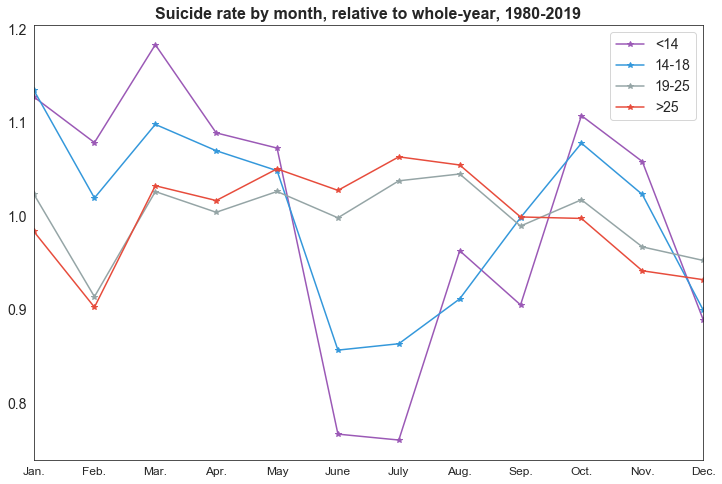

In [148]:
#fig, ax = plt.subplots(1)
rel.plot(figsize=(12, 8), style='-*', color=COLORS)
_ = plt.title('Suicide rate by month, ' + title_str + year_range_str, fontsize=16, weight='heavy')
_ = plt.xticks(fontsize=14)
_ = plt.xlabel('', fontsize=14)
_ = plt.xticks(range(len(rel.index)), rel.index, fontsize=12)
_ = plt.yticks(fontsize=14)
_ = plt.legend(fontsize=14)
#_ = plt.axhline(1.0, color='gray')
if SAVE_FIGS:
    if normalize_by_mean:
        plt.savefig('figures/suicide_rate_by_month_relative_to_mean.png', dpi=300, bbox_inches='tight')
    if normalize_by_month > 0:
        filename = 'figures/suicide_rate_by_month_relative_to_{0}.png'.format(months_map[normalize_by_month])
        plt.savefig(filename, dpi=300, bbox_inches='tight')

In [149]:
suicide_rate_per100k_annualized_by_month

,<14,14-18,19-25,>25
month,,,,
1,0.332630,8.351772,14.487240,15.823328
2,0.318148,7.499289,12.926622,14.513221
3,0.349059,8.078998,14.519148,16.604678
4,0.321206,7.871620,14.205629,16.349807
5,0.316410,7.714503,14.520340,16.895665
6,0.226064,6.300786,14.121849,16.525145
7,0.224198,6.350977,14.682233,17.102449
8,0.283978,6.704360,14.785563,16.962303
9,0.266878,7.344847,13.996800,16.067070


# Regressing

### Set up data

In [150]:
# preview
suicide_rate_per100k_annualized_by_monthyear.head()

,<14,14-18,19-25,>25
1980-01-01,0.176692,6.714798,15.076880,15.312611
1980-02-01,0.201934,6.007977,15.036888,14.570182
1980-03-01,0.252417,6.596995,16.036681,16.444816
1980-04-01,0.227175,5.065550,15.636764,17.150124
1980-05-01,0.100967,6.066879,14.676962,17.131564


In [151]:
df = suicide_rate_per100k_annualized_by_monthyear.copy()
df['year_month'] = [pd.datetime.strftime(x, '%Y-%m') for x in df.index]

In [152]:
# preview
df.head()

,<14,14-18,19-25,>25,year_month
1980-01-01,0.176692,6.714798,15.076880,15.312611,1980-01
1980-02-01,0.201934,6.007977,15.036888,14.570182,1980-02
1980-03-01,0.252417,6.596995,16.036681,16.444816,1980-03
1980-04-01,0.227175,5.065550,15.636764,17.150124,1980-04
1980-05-01,0.100967,6.066879,14.676962,17.131564,1980-05


In [153]:
df = (
    df
    .set_index('year_month')
    .stack()
    .reset_index()
    .rename(columns={
        'level_1': 'age_group',
        0: 'suicide_rate_per100k_annualized'
    })
)
df['year'] = df['year_month'].str[:4]
df['month'] = df['year_month'].str[5:]

In [154]:
df.head()

,year_month,age_group,suicide_rate_per100k_annualized,year,month
0,1980-01,<14,0.176692,1980,01
1,1980-01,14-18,6.714798,1980,01
2,1980-01,19-25,15.076880,1980,01
3,1980-01,>25,15.312611,1980,01
4,1980-02,<14,0.201934,1980,02


In [155]:
SUMMER_MONTHS = ['06', '07', '08']
df['is_summer'] = df['month'].isin(SUMMER_MONTHS)*1.
VACATION_MONTHS = ['06', '07', '08', '12']    # arguably could include February
df['is_vacation'] = df['month'].isin(VACATION_MONTHS)*1.

In [156]:
df.sample(n=5)

,year_month,age_group,suicide_rate_per100k_annualized,year,month,is_summer,is_vacation
220,1984-08,<14,0.150764,1984,08,1.0,1.0
1030,2001-06,19-25,11.891314,2001,06,1.0,1.0
417,1988-09,14-18,8.485869,1988,09,0.0,0.0
486,1990-02,19-25,12.913030,1990,02,0.0,0.0
1125,2003-06,14-18,4.709074,2003,06,1.0,1.0


In [157]:
groups = df['age_group'].unique()
years = df['year'].unique()
dfs_by_group = {
    group: df[df['age_group'] == group]
    for group in groups
}
dfs_by_year = {
    group: {
        year: df[(df['age_group'] == group) & (df['year'] == year)]
        for year in years
    }
    for group in groups
}

### Formulas

In [158]:
BY_MONTH_FML = 'suicide_rate_per100k_annualized ~ C(month, patsy.Treatment(reference="09"))'
BY_MONTH_W_FE_FML = 'suicide_rate_per100k_annualized ~ C(month, patsy.Treatment(reference="09")) + C(year)'
SUMMER_FML = 'suicide_rate_per100k_annualized ~ is_summer'
SUMMER_W_FE_FML = 'suicide_rate_per100k_annualized ~ is_summer + C(year)'
VACATION_FML = 'suicide_rate_per100k_annualized ~ is_vacation'
VACATION_W_FE_FML = 'suicide_rate_per100k_annualized ~ is_vacation + C(year)'

PERCENT_FML = 'np.log(suicide_rate_per100k_annualized + 1) ~ C(month, patsy.Treatment(reference="09"))'
PERCENT_W_FE_FML = 'np.log(suicide_rate_per100k_annualized + 1) ~ C(month, patsy.Treatment(reference="09")) + C(year)'
PCT_SUMMER_FML = 'np.log(suicide_rate_per100k_annualized+1) ~ is_summer'
PCT_SUMMER_W_FE_FML = 'np.log(suicide_rate_per100k_annualized+1) ~ is_summer + C(year)'
PCT_VACATION_FML = 'np.log(suicide_rate_per100k_annualized+1) ~ is_vacation'
PCT_VACATION_W_FE_FML = 'np.log(suicide_rate_per100k_annualized+1) ~ is_vacation + C(year)'

In [159]:
regs_by_month = {}
regs_by_month_w_fe = {}
regs_summer = {}
regs_summer_w_fe = {}
regs_vacation = {}
regs_vacation_w_fe = {}
regs_percent = {}
regs_percent_w_fe = {}

### Whole time period

In [160]:
for group, tmp_df in dfs_by_group.iteritems():
    regs_by_month[group] = sm.formula.ols(data=tmp_df, formula=BY_MONTH_FML).fit()
    regs_by_month_w_fe[group] = sm.formula.ols(data=tmp_df, formula=BY_MONTH_W_FE_FML).fit()
    regs_summer[group] = sm.formula.ols(data=tmp_df, formula=SUMMER_FML).fit()
    regs_summer_w_fe[group] = sm.formula.ols(data=tmp_df, formula=SUMMER_W_FE_FML).fit()
    regs_vacation[group] = sm.formula.ols(data=tmp_df, formula=VACATION_FML).fit()
    regs_vacation_w_fe[group] = sm.formula.ols(data=tmp_df, formula=VACATION_W_FE_FML).fit()
    regs_percent[group] = sm.formula.ols(data=tmp_df, formula=PERCENT_FML).fit()
    regs_percent_w_fe[group] = sm.formula.ols(data=tmp_df, formula=PERCENT_W_FE_FML).fit()

In [161]:
regressor_order = [
    'C(month, patsy.Treatment(reference="09"))[T.01]',
    'C(month, patsy.Treatment(reference="09"))[T.02]',
    'C(month, patsy.Treatment(reference="09"))[T.03]',
    'C(month, patsy.Treatment(reference="09"))[T.04]',
    'C(month, patsy.Treatment(reference="09"))[T.05]',
    'C(month, patsy.Treatment(reference="09"))[T.06]',
    'C(month, patsy.Treatment(reference="09"))[T.07]',
    'C(month, patsy.Treatment(reference="09"))[T.08]',
    'C(month, patsy.Treatment(reference="09"))[T.10]',
    'C(month, patsy.Treatment(reference="09"))[T.11]',
    'C(month, patsy.Treatment(reference="09"))[T.12]',
]

In [162]:
pretty_w_stars = sm.iolib.summary2.summary_col(
    results=regs_by_month_w_fe.values(),
    model_names=regs_by_month_w_fe.keys(),
    regressor_order=regressor_order,
    drop_omitted=True,
    stars=True
)

pretty = sm.iolib.summary2.summary_col(
    results=regs_by_month_w_fe.values(),
    model_names=regs_by_month_w_fe.keys(),
    regressor_order=regressor_order,
    drop_omitted=True,
    stars=False
)

def rename(params_table, months_map=months_map):
    mapping = {}
    for k in params_table.index:
        if 'C(' in k:
            _, month = k.split('[T.')
            month = int(month[:-1])
            mapping[k] = months_map[month]
    return params_table.rename(index=mapping)[GROUP_ORDER]

pretty_w_stars = rename(pretty_w_stars.tables[0])
pretty = rename(pretty.tables[0])

In [163]:
# TODO: SEs here are fucked up. notice they're same for all months for a given age group

In [164]:
pretty_w_stars

,<14,14-18,19-25,>25
Jan.,0.0658***,1.0069***,0.4904**,-0.2437**
,(0.0184),(0.1761),(0.2038),(0.1176)
Feb.,0.0513***,0.1544,-1.0702***,-1.5538***
,(0.0184),(0.1761),(0.2038),(0.1176)
Mar.,0.0822***,0.7342***,0.5223**,0.5376***
,(0.0184),(0.1761),(0.2038),(0.1176)
Apr.,0.0543***,0.5268***,0.2088,0.2827**
,(0.0184),(0.1761),(0.2038),(0.1176)
May,0.0495***,0.3697**,0.5235**,0.8286***
,(0.0184),(0.1761),(0.2038),(0.1176)


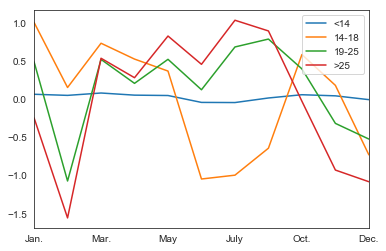

In [165]:
pretty.loc[[k for k in pretty.index if k != '']].astype(float).plot()

In [166]:
# LOTS MORE YOU CAN DO HERE JUST FOR LOOKSIES

In [167]:
print regs_by_month['14-18'].summary()

                                   OLS Regression Results                                  
Dep. Variable:     suicide_rate_per100k_annualized   R-squared:                       0.161
Model:                                         OLS   Adj. R-squared:                  0.142
Method:                              Least Squares   F-statistic:                     8.181
Date:                             Fri, 06 Aug 2021   Prob (F-statistic):           3.72e-13
Time:                                     09:15:36   Log-Likelihood:                -884.41
No. Observations:                              480   AIC:                             1793.
Df Residuals:                                  468   BIC:                             1843.
Df Model:                                       11                                         
Covariance Type:                         nonrobust                                         
                                                      coef    std err          t

In [168]:
print regs_percent['14-18'].summary()

                                         OLS Regression Results                                        
Dep. Variable:     np.log(suicide_rate_per100k_annualized + 1)   R-squared:                       0.165
Model:                                                     OLS   Adj. R-squared:                  0.145
Method:                                          Least Squares   F-statistic:                     8.398
Date:                                         Fri, 06 Aug 2021   Prob (F-statistic):           1.51e-13
Time:                                                 09:15:39   Log-Likelihood:                 139.66
No. Observations:                                          480   AIC:                            -255.3
Df Residuals:                                              468   BIC:                            -205.2
Df Model:                                                   11                                         
Covariance Type:                                     nonrobust  

### By year

In [219]:
regs_by_year['<14']['1986'].summary()

C:\Users\basil\Anaconda3\envs\py2\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                  
===========================================================================================
Dep. Variable:     suicide_rate_per100k_annualized   R-squared:                       0.217
Model:                                         OLS   Adj. R-squared:                  0.139
Method:                              Least Squares   F-statistic:                     2.774
Date:                             Mon, 09 Aug 2021   Prob (F-statistic):              0.127
Time:                                     15:43:53   Log-Likelihood:                 11.113
No. Observations:                               12   AIC:                            -18.23
Df Residuals:                                   10   BIC:                            -17.26
Df Model:                                        1                                         
Covariance Type:                         nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2997      0.035      8.565      0.000       0.222       0.378
is_summer     -0.1166      0.070     -1.665      0.127      -0.273       0.039
==============================================================================
Omnibus:                        7.710   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.021   Jarque-Bera (JB):                3.573
Skew:                           1.178   Prob(JB):                        0.168
Kurtosis:                       4.265   Cond. No.                         2.48
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [169]:
regs_by_year = {
    group: {}
    for group in dfs_by_year
}
pct_regs_by_year = {
    group: {}
    for group in dfs_by_year
}

In [170]:
for group in regs_by_year:
    for year in dfs_by_year[group]:
        regs_by_year[group][year] = sm.formula.ols(data=dfs_by_year[group][year], formula=SUMMER_FML).fit()
        pct_regs_by_year[group][year] = sm.formula.ols(data=dfs_by_year[group][year], formula=PCT_SUMMER_FML).fit()

In [171]:
def get_by_year(regs_by_year, func):
    df = {
        group: {
            year: func(regs_by_year[group][year])
            for year in regs_by_year[group]
        }
        for group in regs_by_year
    }
    return df

In [172]:
get_params = lambda x: x.params['is_summer']
get_intercept = lambda x: x.params['Intercept']
get_se = lambda x: x.bse['is_summer']
get_ci = lambda x: x.conf_int().loc['is_summer']

params_by_year = get_by_year(regs_by_year, get_params)
params_by_year = pd.DataFrame(params_by_year)[GROUP_ORDER]
params_by_year.index = pd.to_datetime(params_by_year.index)

intercept_by_year = get_by_year(regs_by_year, get_intercept)
intercept_by_year = pd.DataFrame(intercept_by_year)[GROUP_ORDER]
intercept_by_year.index = pd.to_datetime(intercept_by_year.index)

se_by_year = get_by_year(regs_by_year, get_se)
se_by_year = pd.DataFrame(se_by_year)[GROUP_ORDER]
se_by_year.index = pd.to_datetime(se_by_year.index)

ci_by_year = get_by_year(regs_by_year, get_ci)

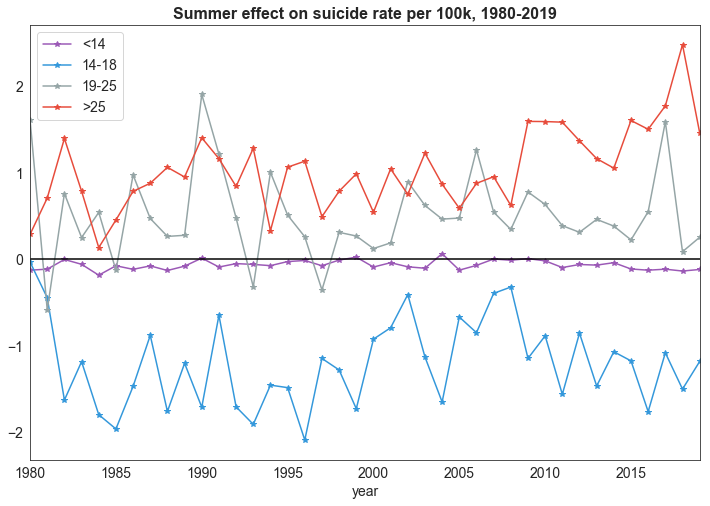

In [173]:
params_by_year.plot(figsize=(12, 8), style='-*', color=COLORS)
_ = plt.title('Summer effect on suicide rate per 100k' + year_range_str, fontsize=16, weight='heavy')
_ = plt.xticks(fontsize=14)
_ = plt.xlabel('year', fontsize=14)
_ = plt.yticks(fontsize=14)
_ = plt.axhline(0.0, color='k')
_ = plt.legend(fontsize=14)
if SAVE_FIGS:
    plt.savefig('figures/summer_coefficient.png', dpi=300, bbox_inches='tight')

In [174]:
pct_params_by_year = get_by_year(pct_regs_by_year, get_params)
pct_params_by_year = pd.DataFrame(pct_params_by_year)[GROUP_ORDER]
pct_params_by_year.index = pd.to_datetime(pct_params_by_year.index)

pct_se_by_year = get_by_year(pct_regs_by_year, get_se)
pct_se_by_year = pd.DataFrame(pct_se_by_year)[GROUP_ORDER]
pct_se_by_year.index = pd.to_datetime(pct_se_by_year.index)

pct_ci_by_year = get_by_year(pct_regs_by_year, get_ci)

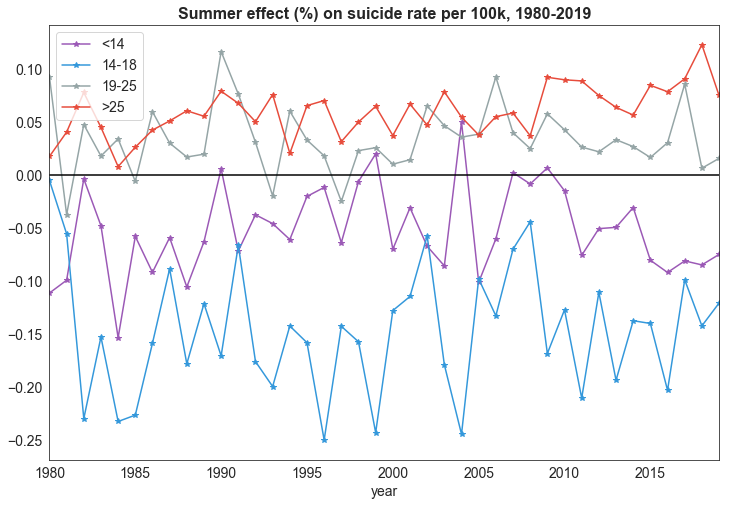

In [175]:
pct_params_by_year.plot(figsize=(12, 8), style='-*', color=COLORS)
_ = plt.title('Summer effect (%) on suicide rate per 100k' + year_range_str, fontsize=16, weight='heavy')
_ = plt.xticks(fontsize=14)
_ = plt.xlabel('year', fontsize=14)
_ = plt.yticks(fontsize=14)
_ = plt.axhline(0.0, color='k')
_ = plt.legend(fontsize=14)
if SAVE_FIGS:
    plt.savefig('figures/summer_pct_coefficient.png', dpi=300, bbox_inches='tight')

# BOTE calculation

In [203]:
summer_rate = suicide_rate_per100k_annualized_by_month.loc[6:8].mean()
restofyear_minus_summer = suicide_rate_per100k_annualized_by_month - summer_rate
restofyear_minus_summer = restofyear_minus_summer.loc[range(1, 6) + range(9, 13)]

In [211]:
pop_latest = pop_by_group.iloc[-1]
pop_latest_div_100k = pop_latest/100000

In [214]:
(restofyear_minus_summer*pop_latest_div_100k).sum()

<14        339.936234
14-18     2270.116246
19-25    -1391.244882
>25     -20604.410140
dtype: float64